# Работа с YOLO

Для начала переключим среду выполнения: Среда выполнения --> Сменить среду выполнения --> T4 GPU .

#YOLOv5

## Установка зависимостей

In [1]:
# Клонирование репозитория YOLOv5
!git clone https://github.com/ultralytics/yolov5  # клонирование репозитория
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16954, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 16954 (delta 76), reused 95 (delta 45), pack-reused 16805 (from 1)
Receiving objects: 100% (16954/16954), 15.71 MiB | 15.71 MiB/s, done.
Resolving deltas: 100% (11609/11609), done.
/content/yolov5
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [2]:
!pip install -qr requirements.txt  # установка зависимостей (игнорировать ошибки)
import torch

from IPython.display import Image, clear_output  # для отображения изображений
from utils.downloads import attempt_download  # для загрузки моделей/датасетов

print('Настройка завершена. Используется torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.8 MB/s eta 0:00:00
Настройка завершена. Используется torch 2.4.0+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


## Загрузка датасета

Здесь мы загружаем по API датасет, который взяли с RoboFlow (https://universe.roboflow.com/ad-tm5st/only-helmet2)

In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="xL5MrCAjRN0Lou0mYJIV")
project = rf.workspace("ad-tm5st").project("only-helmet2")
version = project.version(2)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Переходим в директорию yolo

In [5]:
%cd /content/yolov5

/content/yolov5


In [6]:
# это YAML-файл, который Roboflow сгенерировал для нас, и который мы загружаем в этот ноутбук с нашими данными
%cat {dataset.location}/data.yaml

names:
- Helmet
- helmet_blue
- helmet_white
- helmet_yellow
- kask
nc: 5
roboflow:
  license: CC BY 4.0
  project: only-helmet2
  url: https://universe.roboflow.com/ad-tm5st/only-helmet2/dataset/2
  version: 2
  workspace: ad-tm5st
test: ../test/images
train: only-helmet2-2/train/images
val: only-helmet2-2/valid/images


## Определение конфигурации модели и её архитектуры

Мы напишем YAML-скрипт, который определяет параметры для нашей модели, такие как количество классов, якоря (anchors), и каждый слой.

Эти ячейки должны быть стандартные, но если есть желание, можно поправлять

In [7]:
# определение количества классов на основе YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])


In [8]:
#это конфигурация модели, которую мы будем использовать в нашем обучающем примере
%cat /content/yolov5/models/yolov5s.yaml


# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [9]:
#настройка iPython для записи в файл с использованием переменных
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# параметры
nc: {num_classes}  # количество классов
depth_multiple: 0.33  # множитель глубины модели
width_multiple: 0.50  # множитель каналов слоя

# якоря
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [откуда, количество, модуль, аргументы]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 голова
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # объединение с backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # объединение с backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-малый)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # объединение с головой P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-средний)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # объединение с головой P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-крупный)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]


## Обучение кастомного детектора YOLOv5

### Далее мы начнем обучение

Здесь мы можем передать несколько аргументов:
- **img:** задаёт размер входного изображения
- **batch:** определяет размер батча
- **epochs:** задаёт количество эпох обучения (Примечание: обычно это 3000 и более!)
- **data:** указывает путь к нашему YAML-файлу
- **cfg:** задаёт конфигурацию модели
- **weights:** указывает пользовательский путь к весам (Примечание: вы можете скачать веса из [папки Ultralytics на Google Drive](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** имена результатов
- **nosave:** сохранять только финальную контрольную точку
- **cache:** кэшировать изображения для ускорения обучения

### Обучение yolov5s на пользовательских данных в течение 25 эпох
### Замер производительности

In [11]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 25 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results --cache


/content/yolov5
2024-09-17 07:46:26.283932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 07:46:26.304196: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 07:46:26.313869: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 07:46:26.339242: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 07:46:27.526524: W

## Просмотр производительности нашей модели YOLOv5

Вы можете просмотреть графики обучения, связанные с обучением, в папке `/content/yolov5/runs/train/yolov5s_results/results.png`.

Потери на обучении и метрики производительности также сохраняются в Tensorboard и в лог-файл, указанный выше с помощью флага **--name** при обучении. В нашем случае мы назвали его `yolov5s_results`.

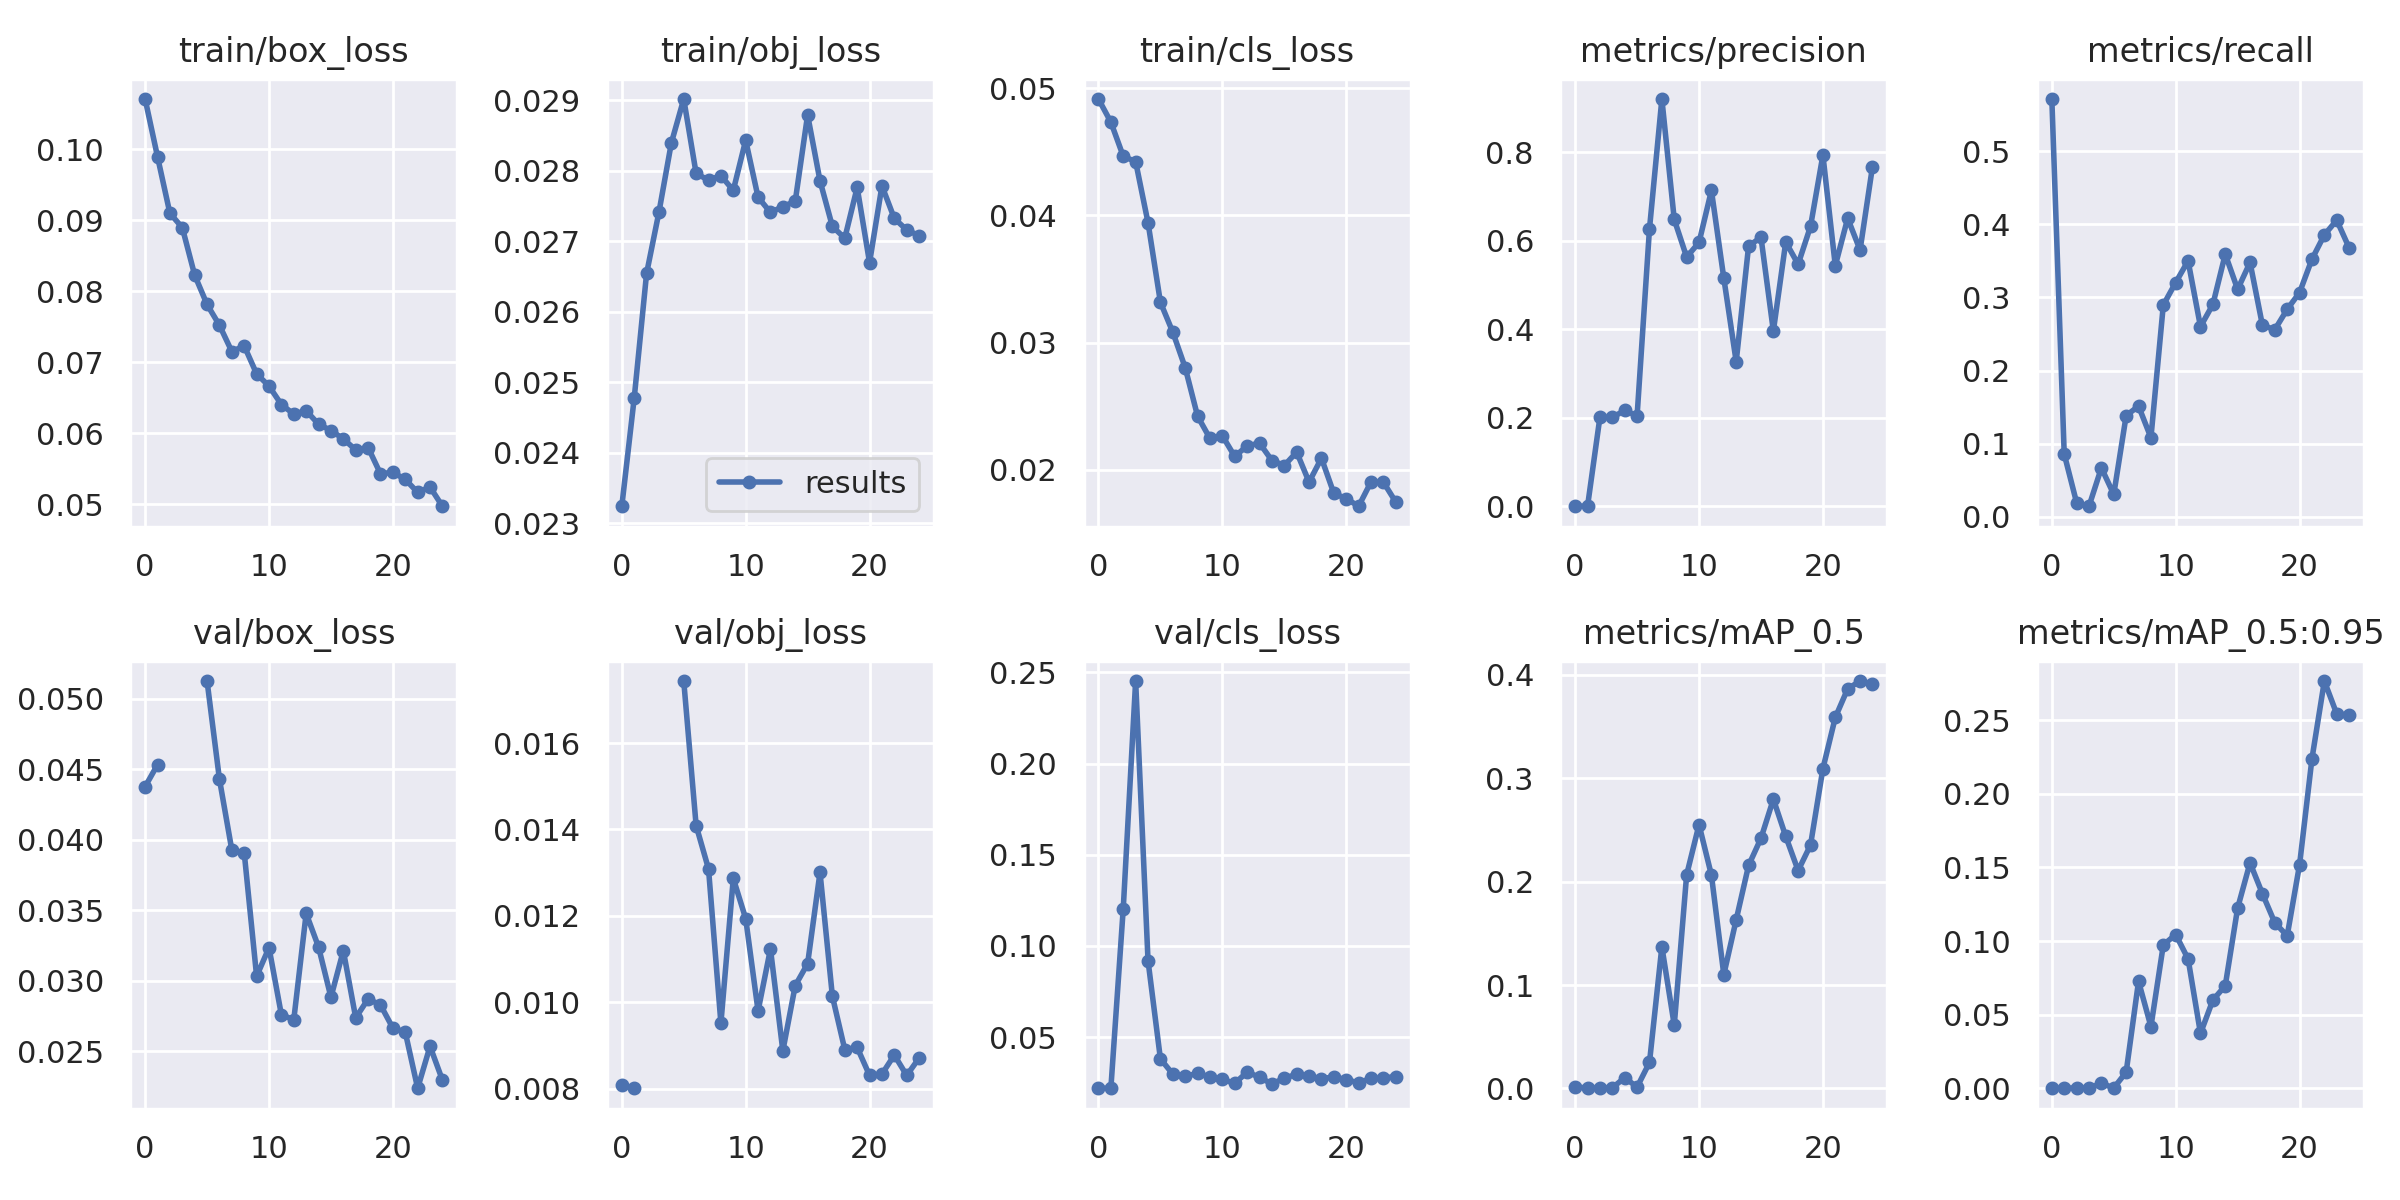

In [12]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

## Визуализируем наши обучающие данные с метками

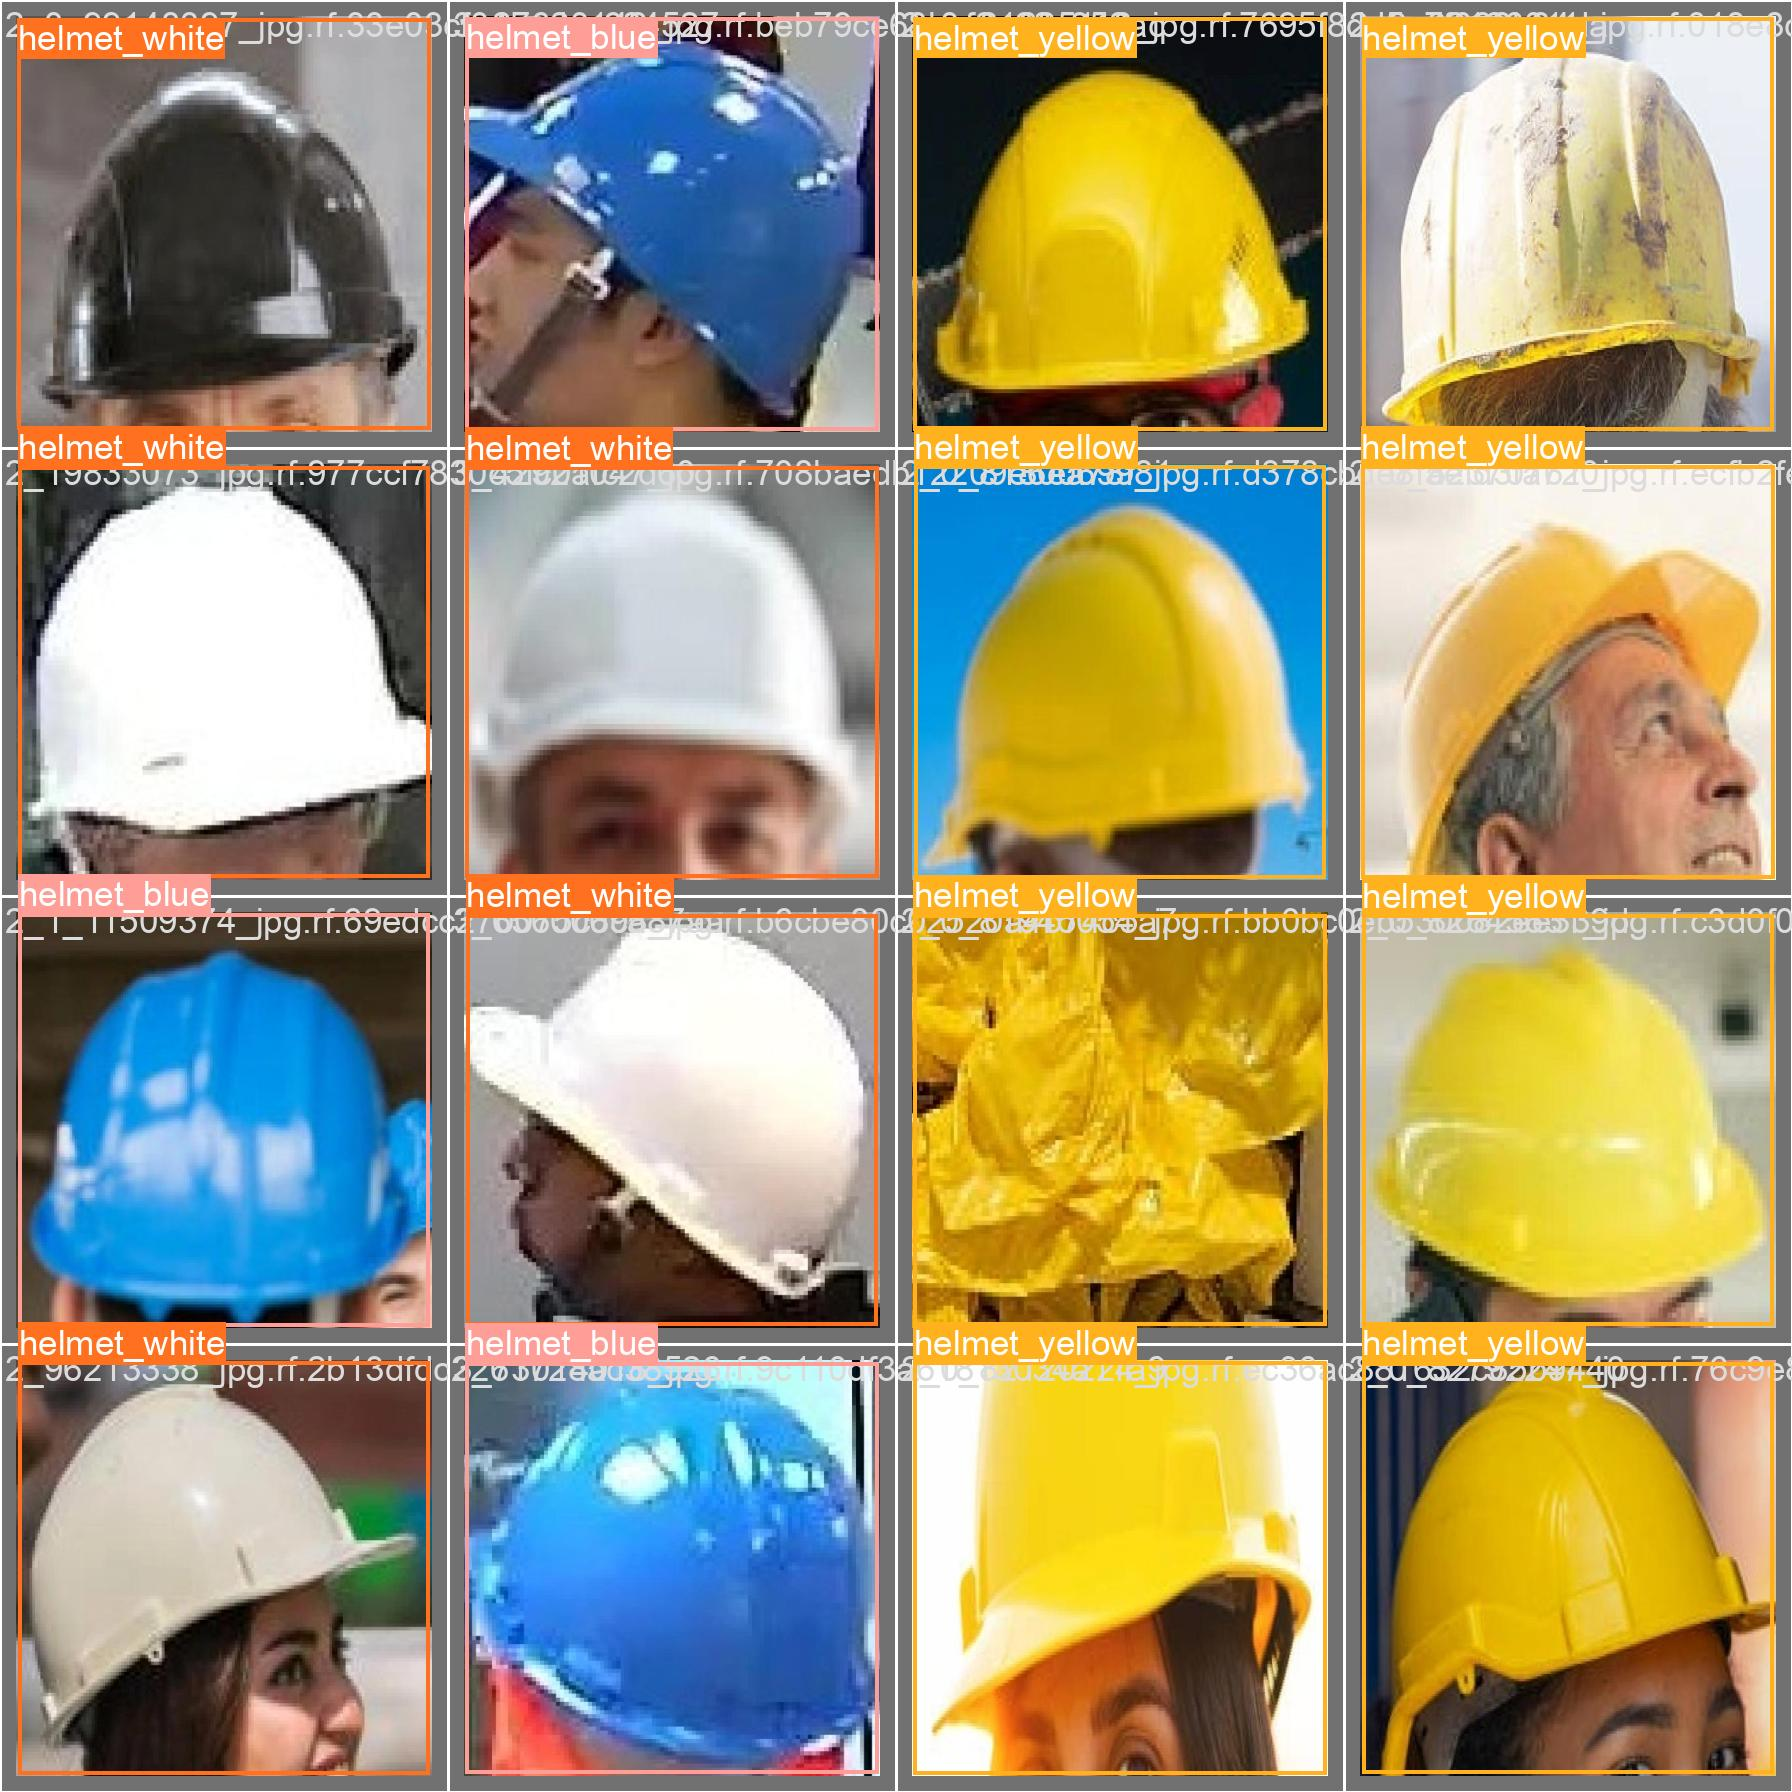

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

ОРИГИНАЛЬНЫЕ УВЕЛИЧЕННЫЕ ОБУЧАЮЩИЕ ДАННЫЕ:


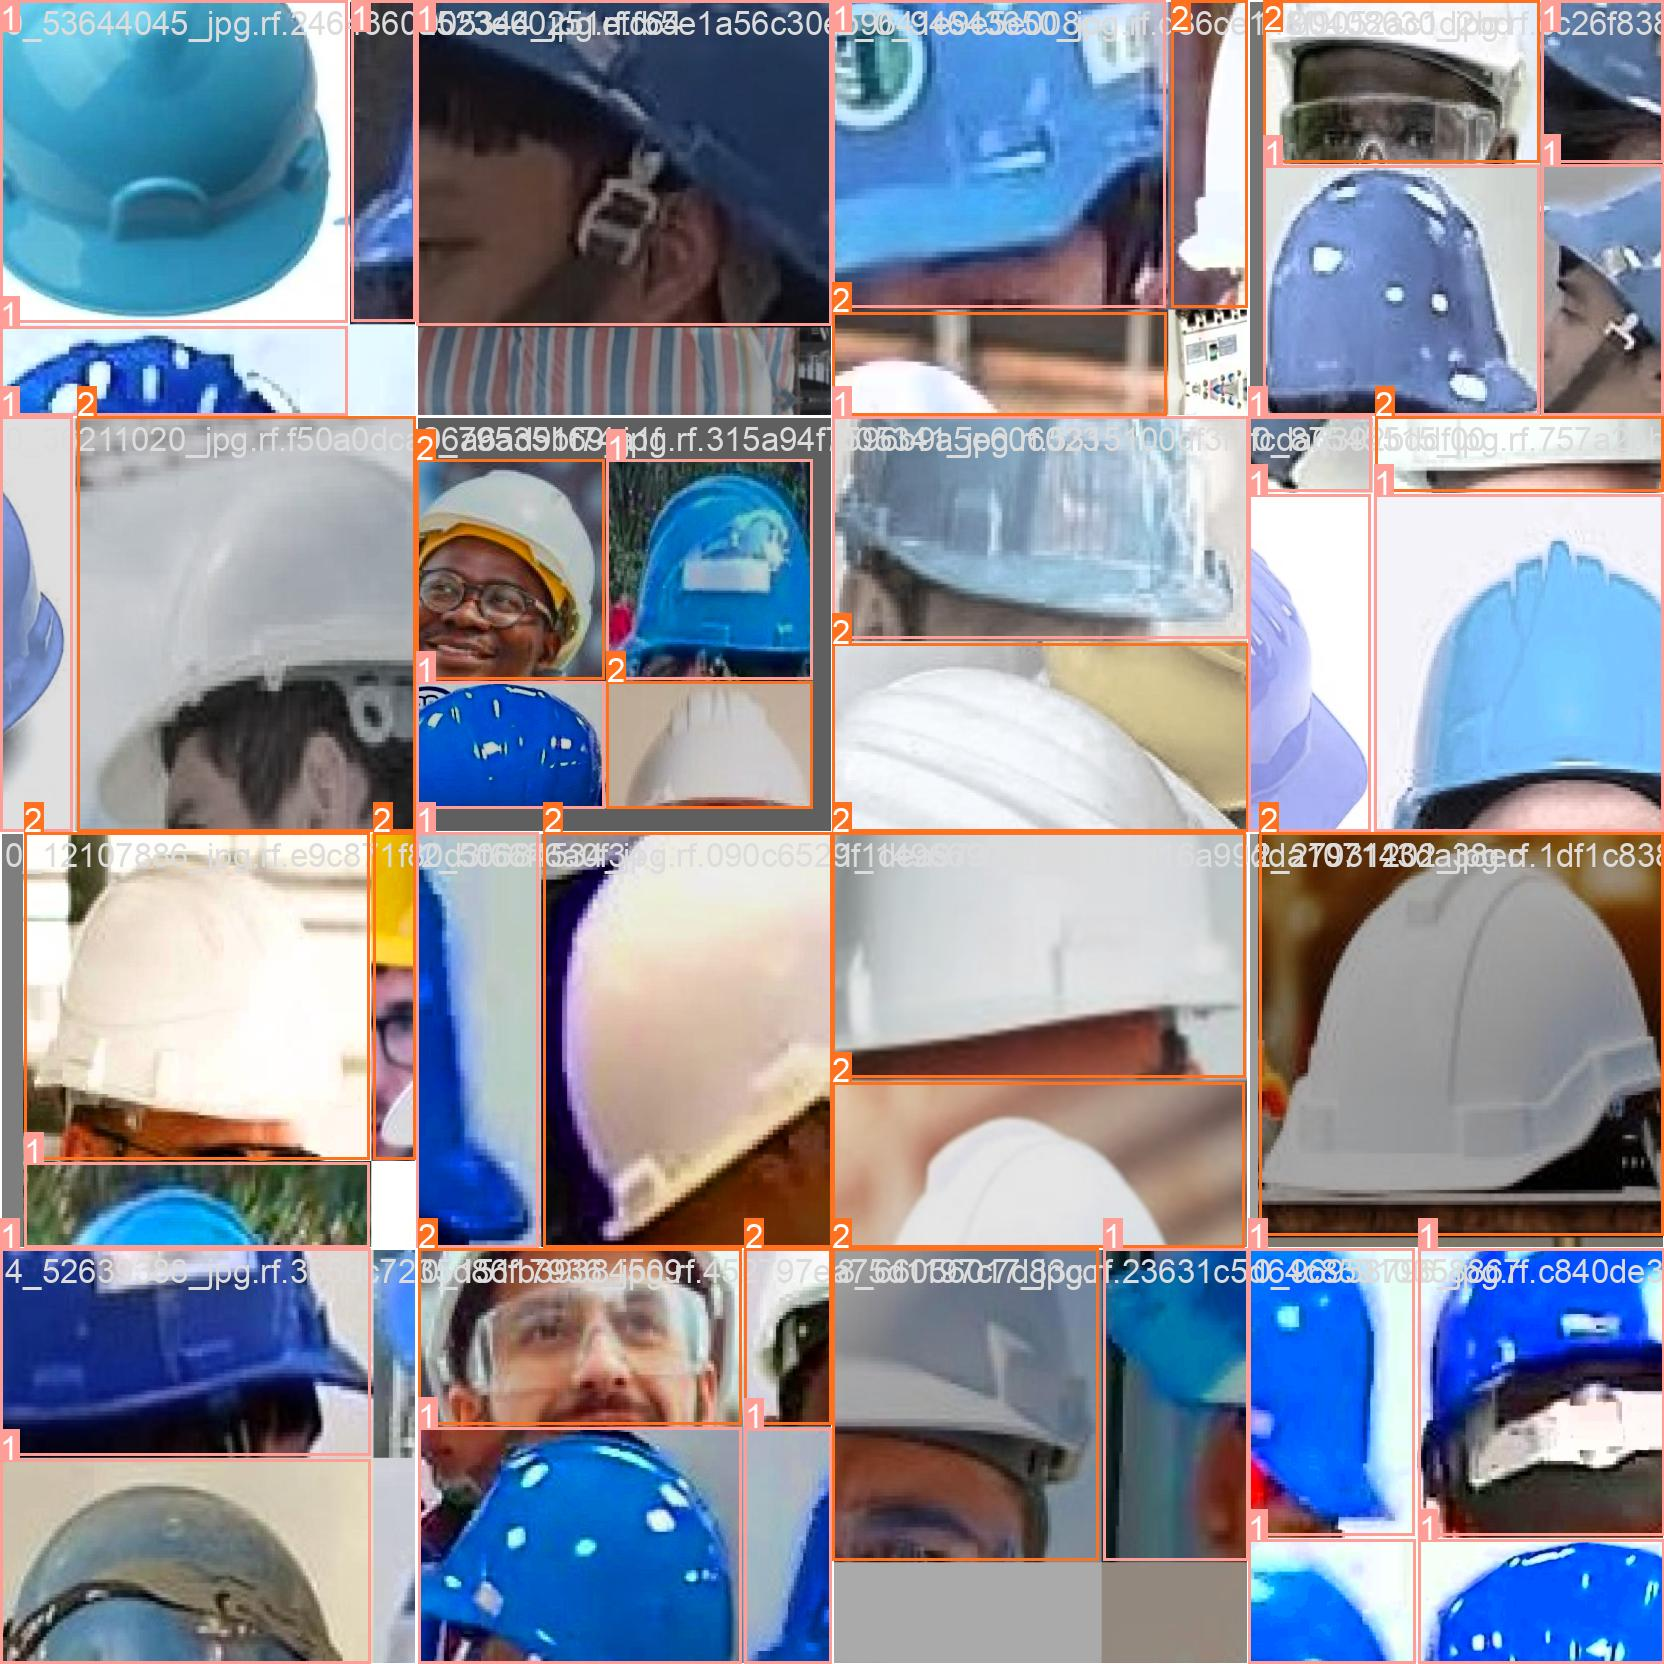

In [ ]:
# выводим пример увеличенных обучающих данных
print("ОРИГИНАЛЬНЫЕ УВЕЛИЧЕННЫЕ ОБУЧАЮЩИЕ ДАННЫЕ:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)


## Запуск инференса с использованием обученных весов

Далее мы можем выполнить инференс с помощью сохранённой контрольной точки на всех изображениях в папке `test/images`, чтобы понять, как наша модель работает на тестовом наборе данных.

In [ ]:
# обученные веса по умолчанию сохраняются в нашей папке весов
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


Здесь есть скрипт для просмотра фото не тестовых данных, для начала нужно указать название датасета "helmet-3", далее тут же нужно указать размер изображения (лучше делать на таких же размерах, что и указывали при обучении модели). Так же есть параметр `--conf` он нужен для того, чтобы обозначать минимум для уверенности модели, сейчас стоит 0.6 -> модель будет отображать каски с увереностью выше 60 %

In [13]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.6 --source only-helmet2-2/test/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=only-helmet2-2/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov5/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future r

Из вывода можно увидеть то что в некоторых моментах каску не распознает, это получается потому что модель плохо обучилась на 25 эпохах, нужно тренировать минимум на 100

Далее выводим изображения

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp3/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))

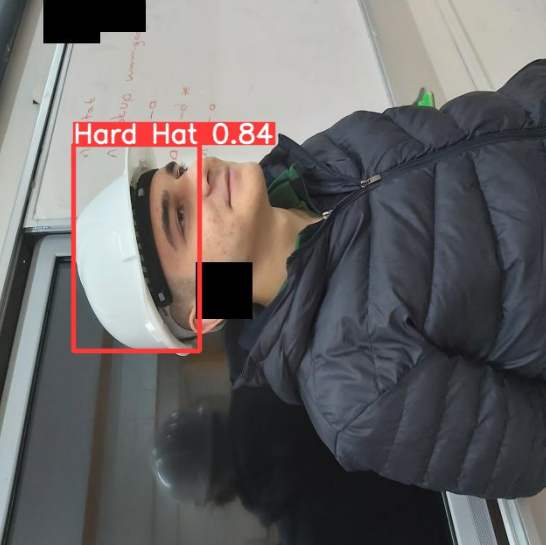

Теперь давайте перезапустим полностью среду выполнения,чтобы попробовать тоже самое, только на YOLOv8.

#YOLOv8

## Установка зависимостей

In [ ]:
!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()
from ultralytics import YOLO

from IPython.display import display, Image

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.6/112.6 GB disk)


Или можно прямо из git

In [ ]:
%cd {HOME}
!git clone github.com/ultralytics/ultralytics
%cd {HOME}/ultralytics
!pip install -e .

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.0/112.6 GB disk)


## Также загружаем датасет из Roboflow

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="xL5MrCAjRN0Lou0mYJIV")
project = rf.workspace("ad-tm5st").project("only-helmet2")
version = project.version(2)
dataset = version.download("yolov8")


/content/datasets
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to only-helmet2-2 in yolov8:: 100%|██████████| 2736/2736 [00:01<00:00, 2041.71it/s]


In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=25 imgsz=416 plots=True

/content
100% 21.5M/21.5M [00:00<00:00, 122MB/s] 
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

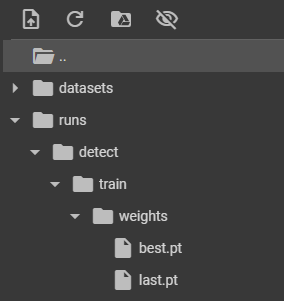

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					   R_curve.png	       val_batch0_labels.jpg
confusion_matrix_normalized.png			   results.csv	       val_batch0_pred.jpg
confusion_matrix.png				   results.png	       val_batch1_labels.jpg
events.out.tfevents.1726547413.4aec082512cf.662.0  train_batch0.jpg    val_batch1_pred.jpg
F1_curve.png					   train_batch1.jpg    val_batch2_labels.jpg
labels_correlogram.jpg				   train_batch2.jpg    val_batch2_pred.jpg
labels.jpg					   train_batch645.jpg  weights
P_curve.png					   train_batch646.jpg
PR_curve.png					   train_batch647.jpg


/content


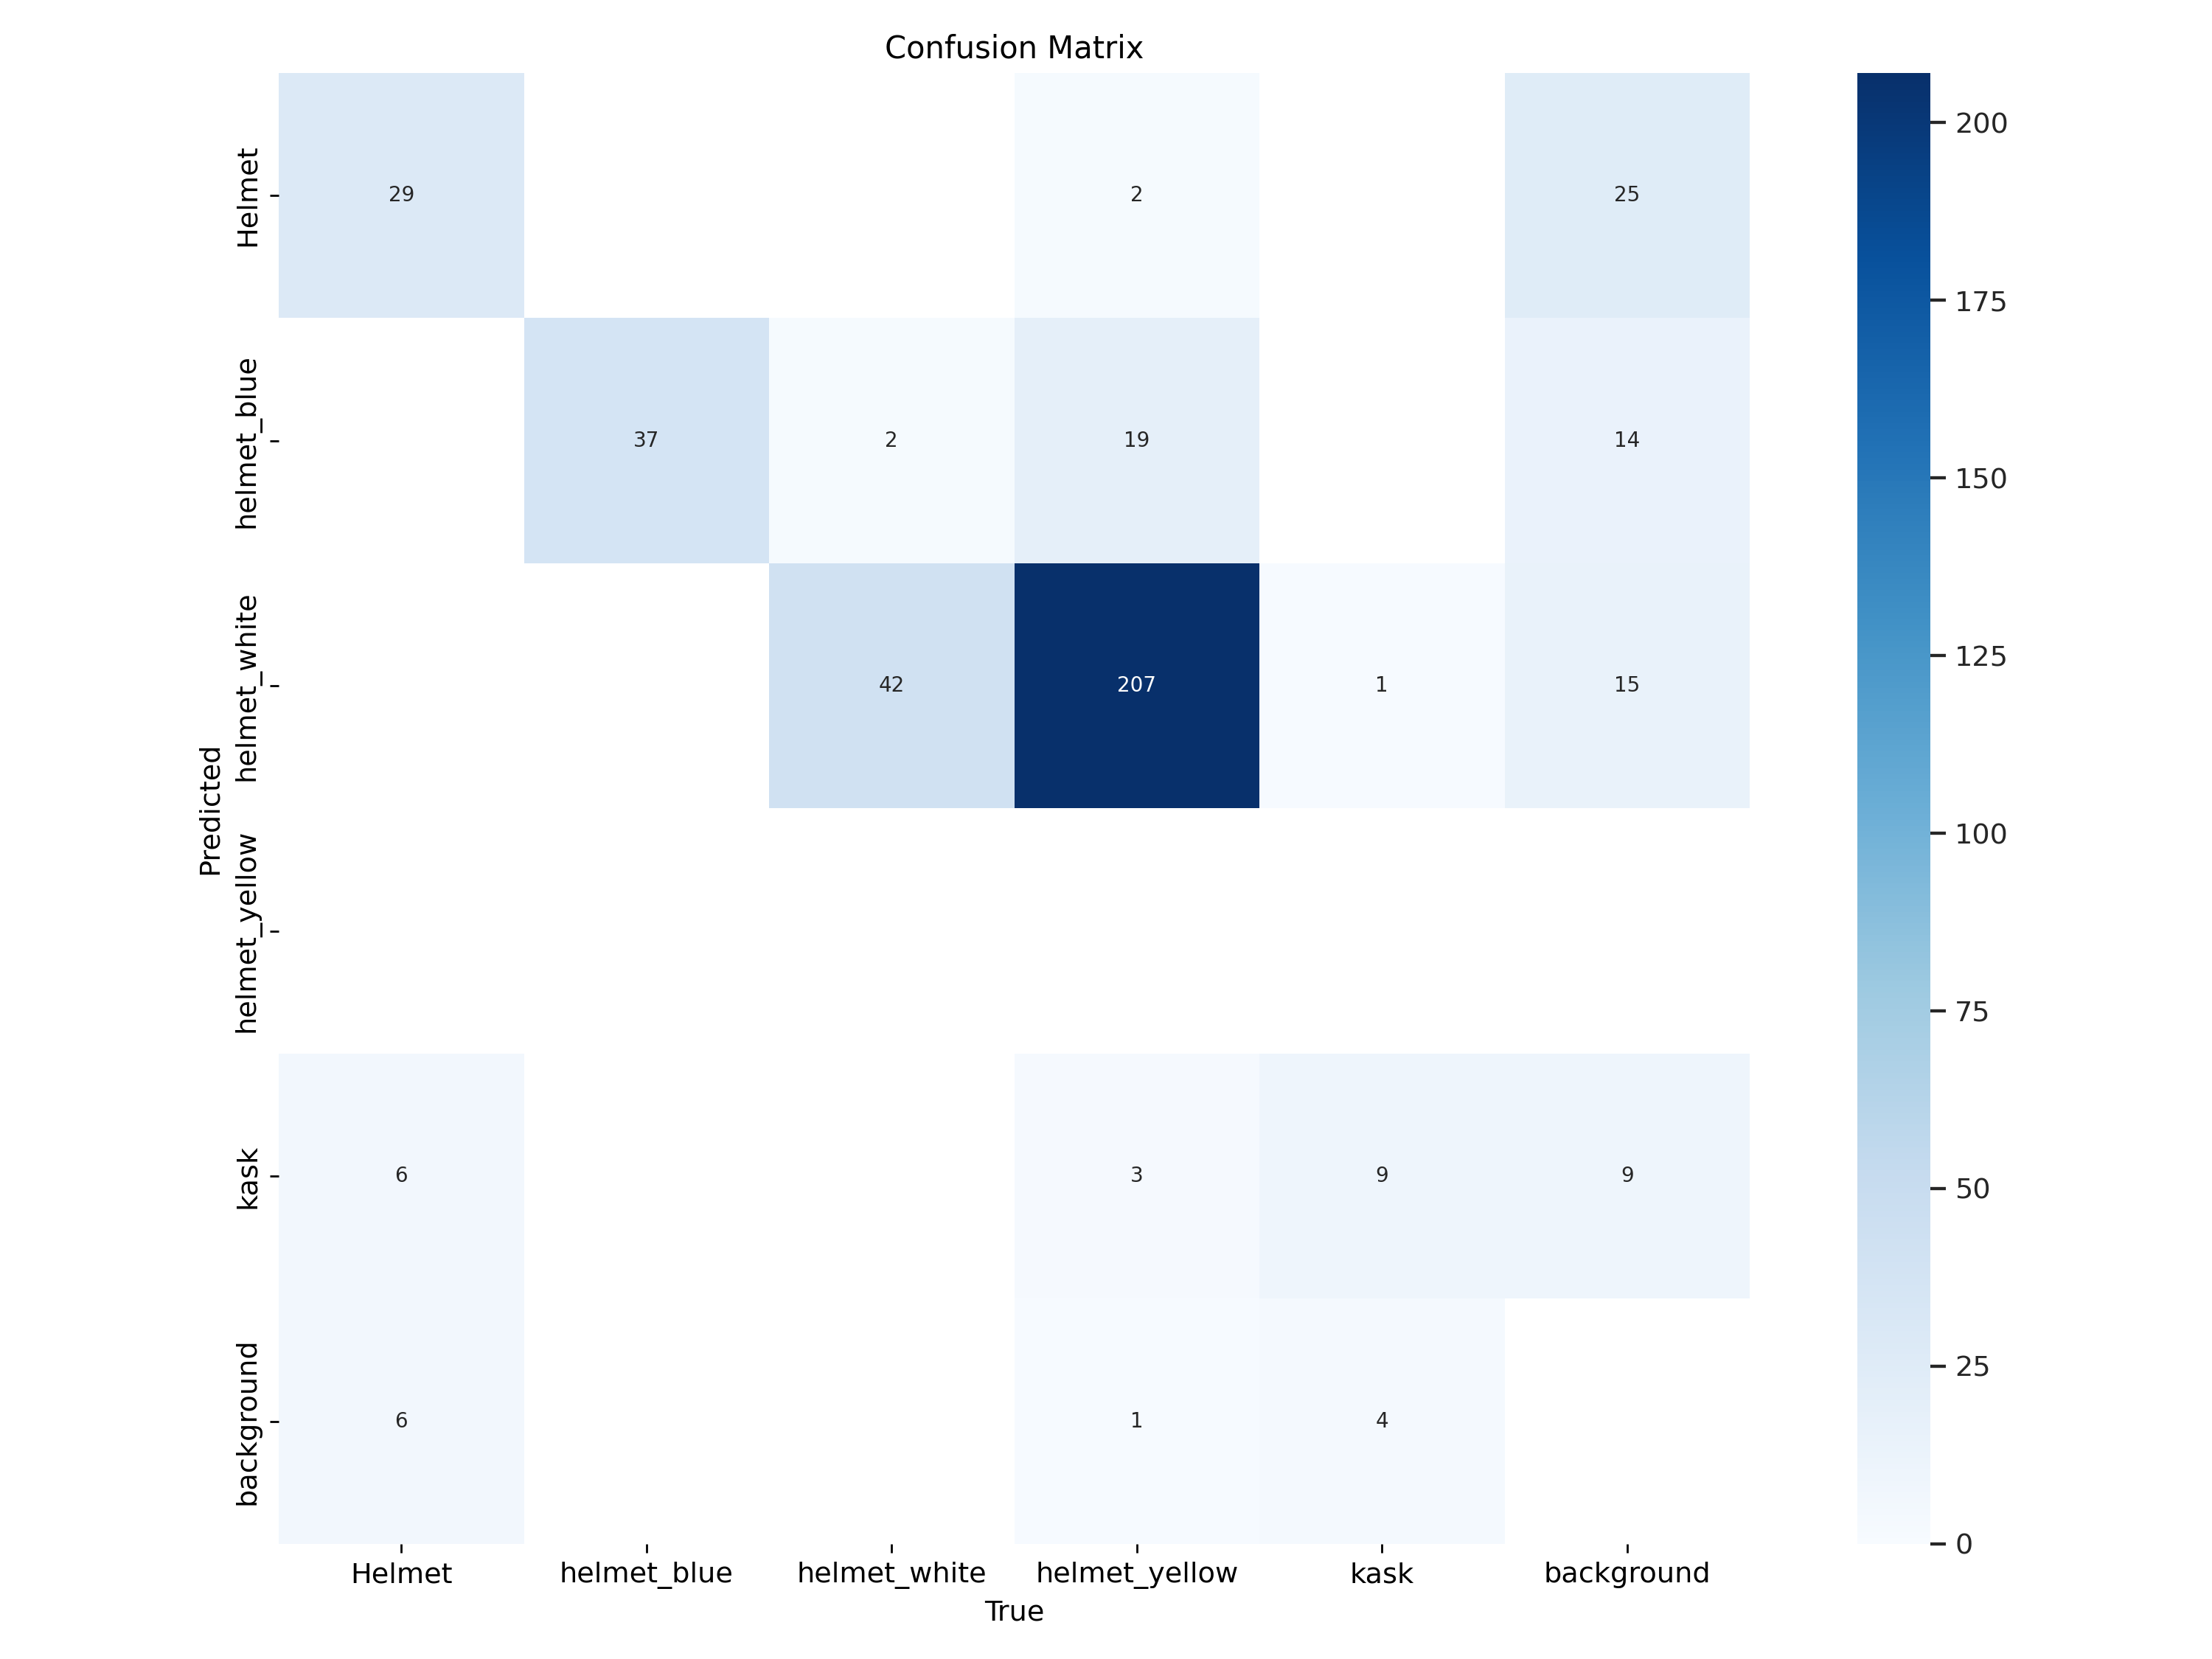

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


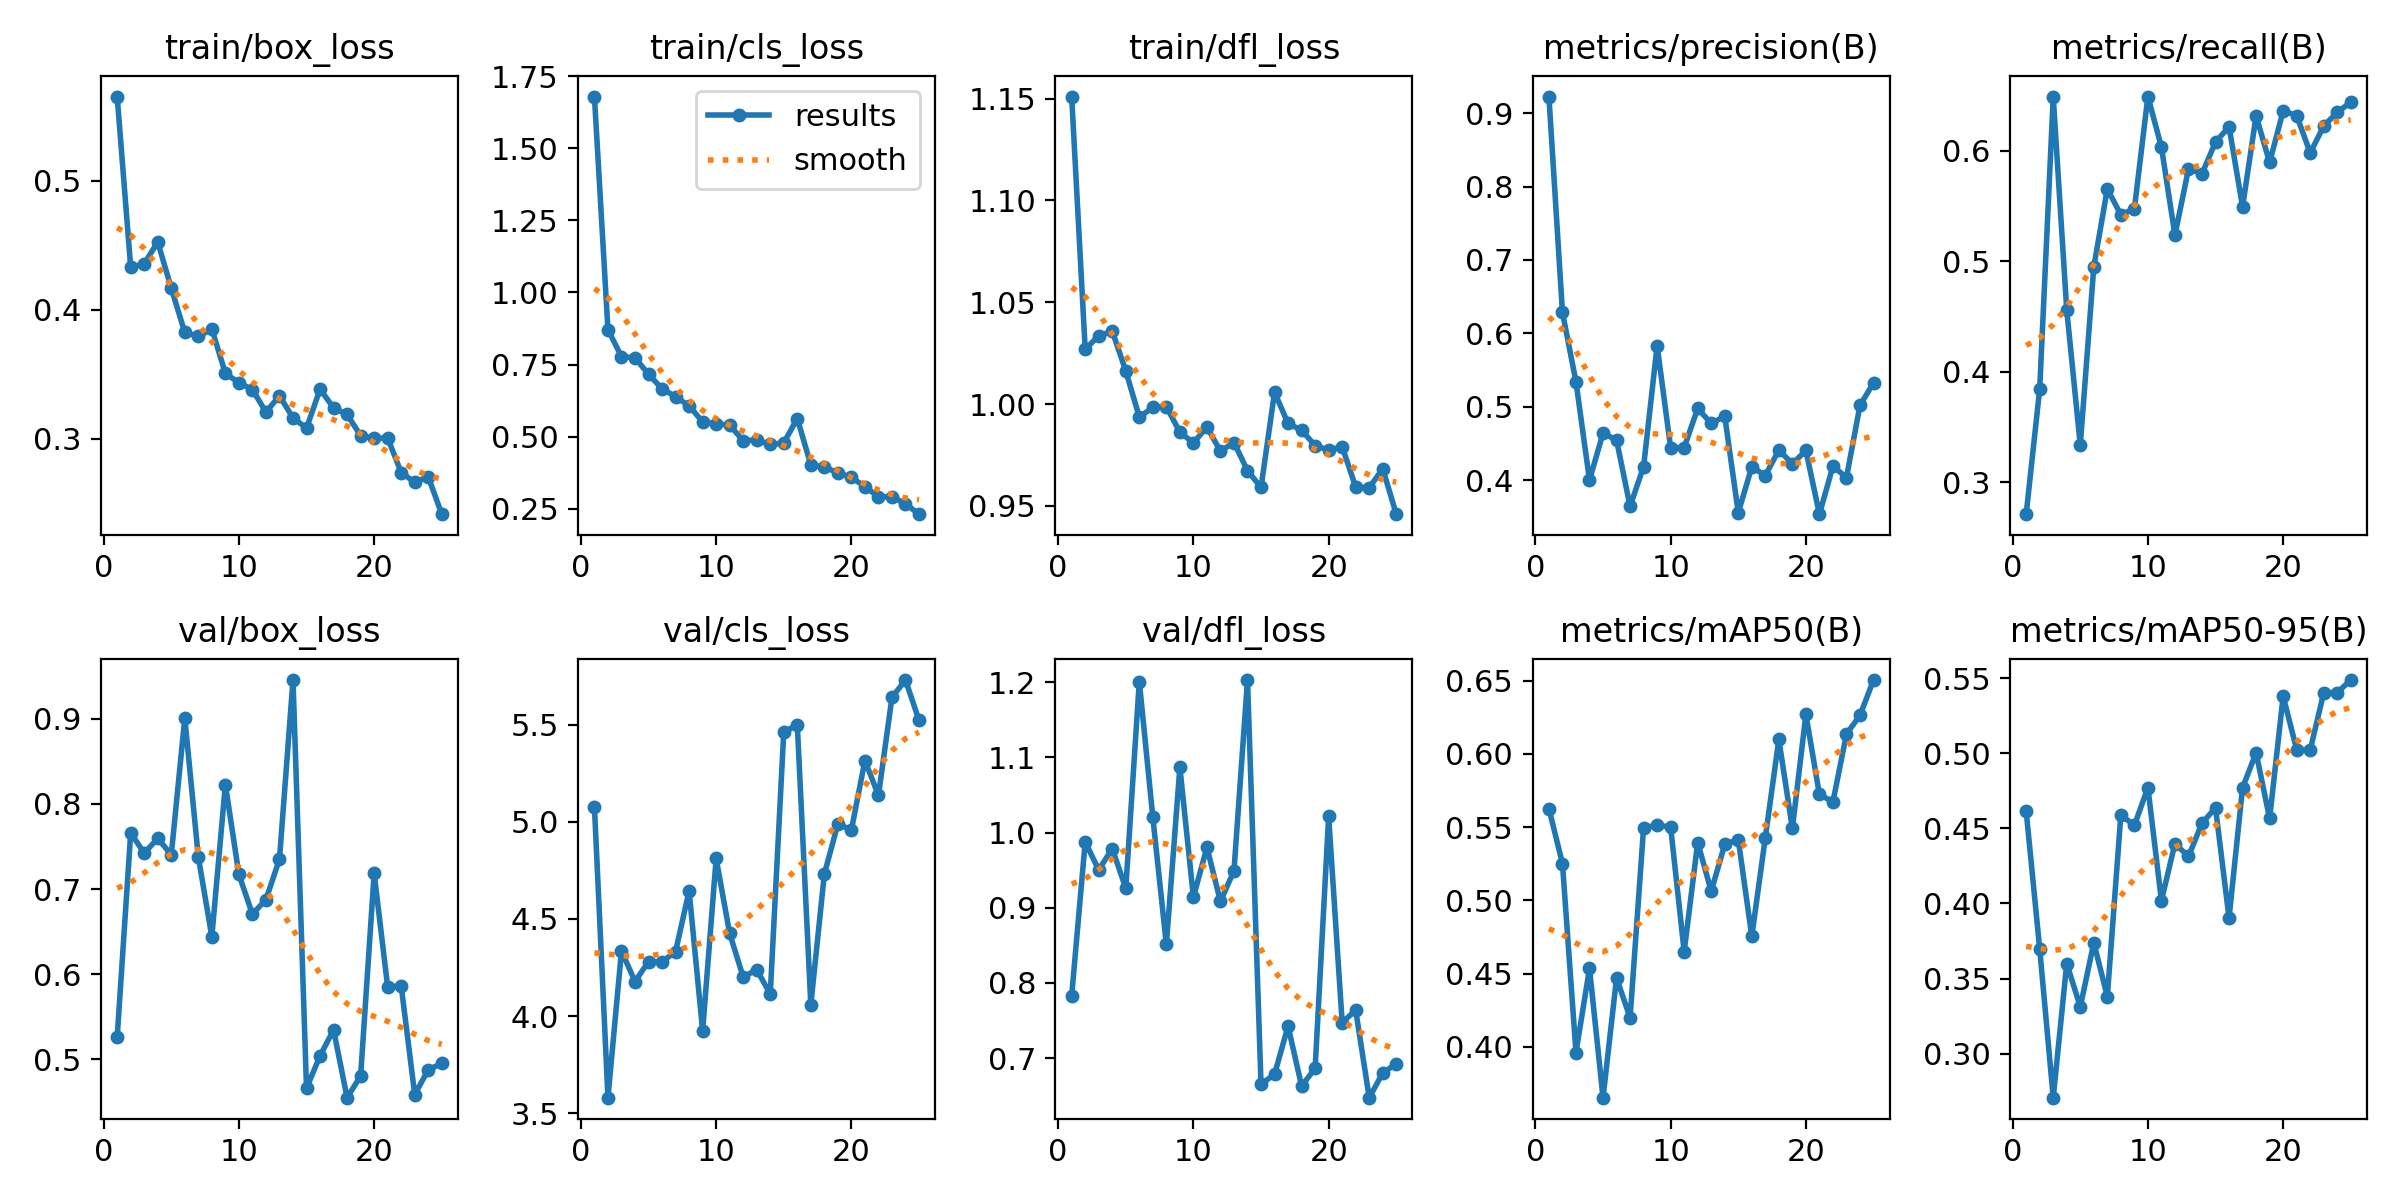

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


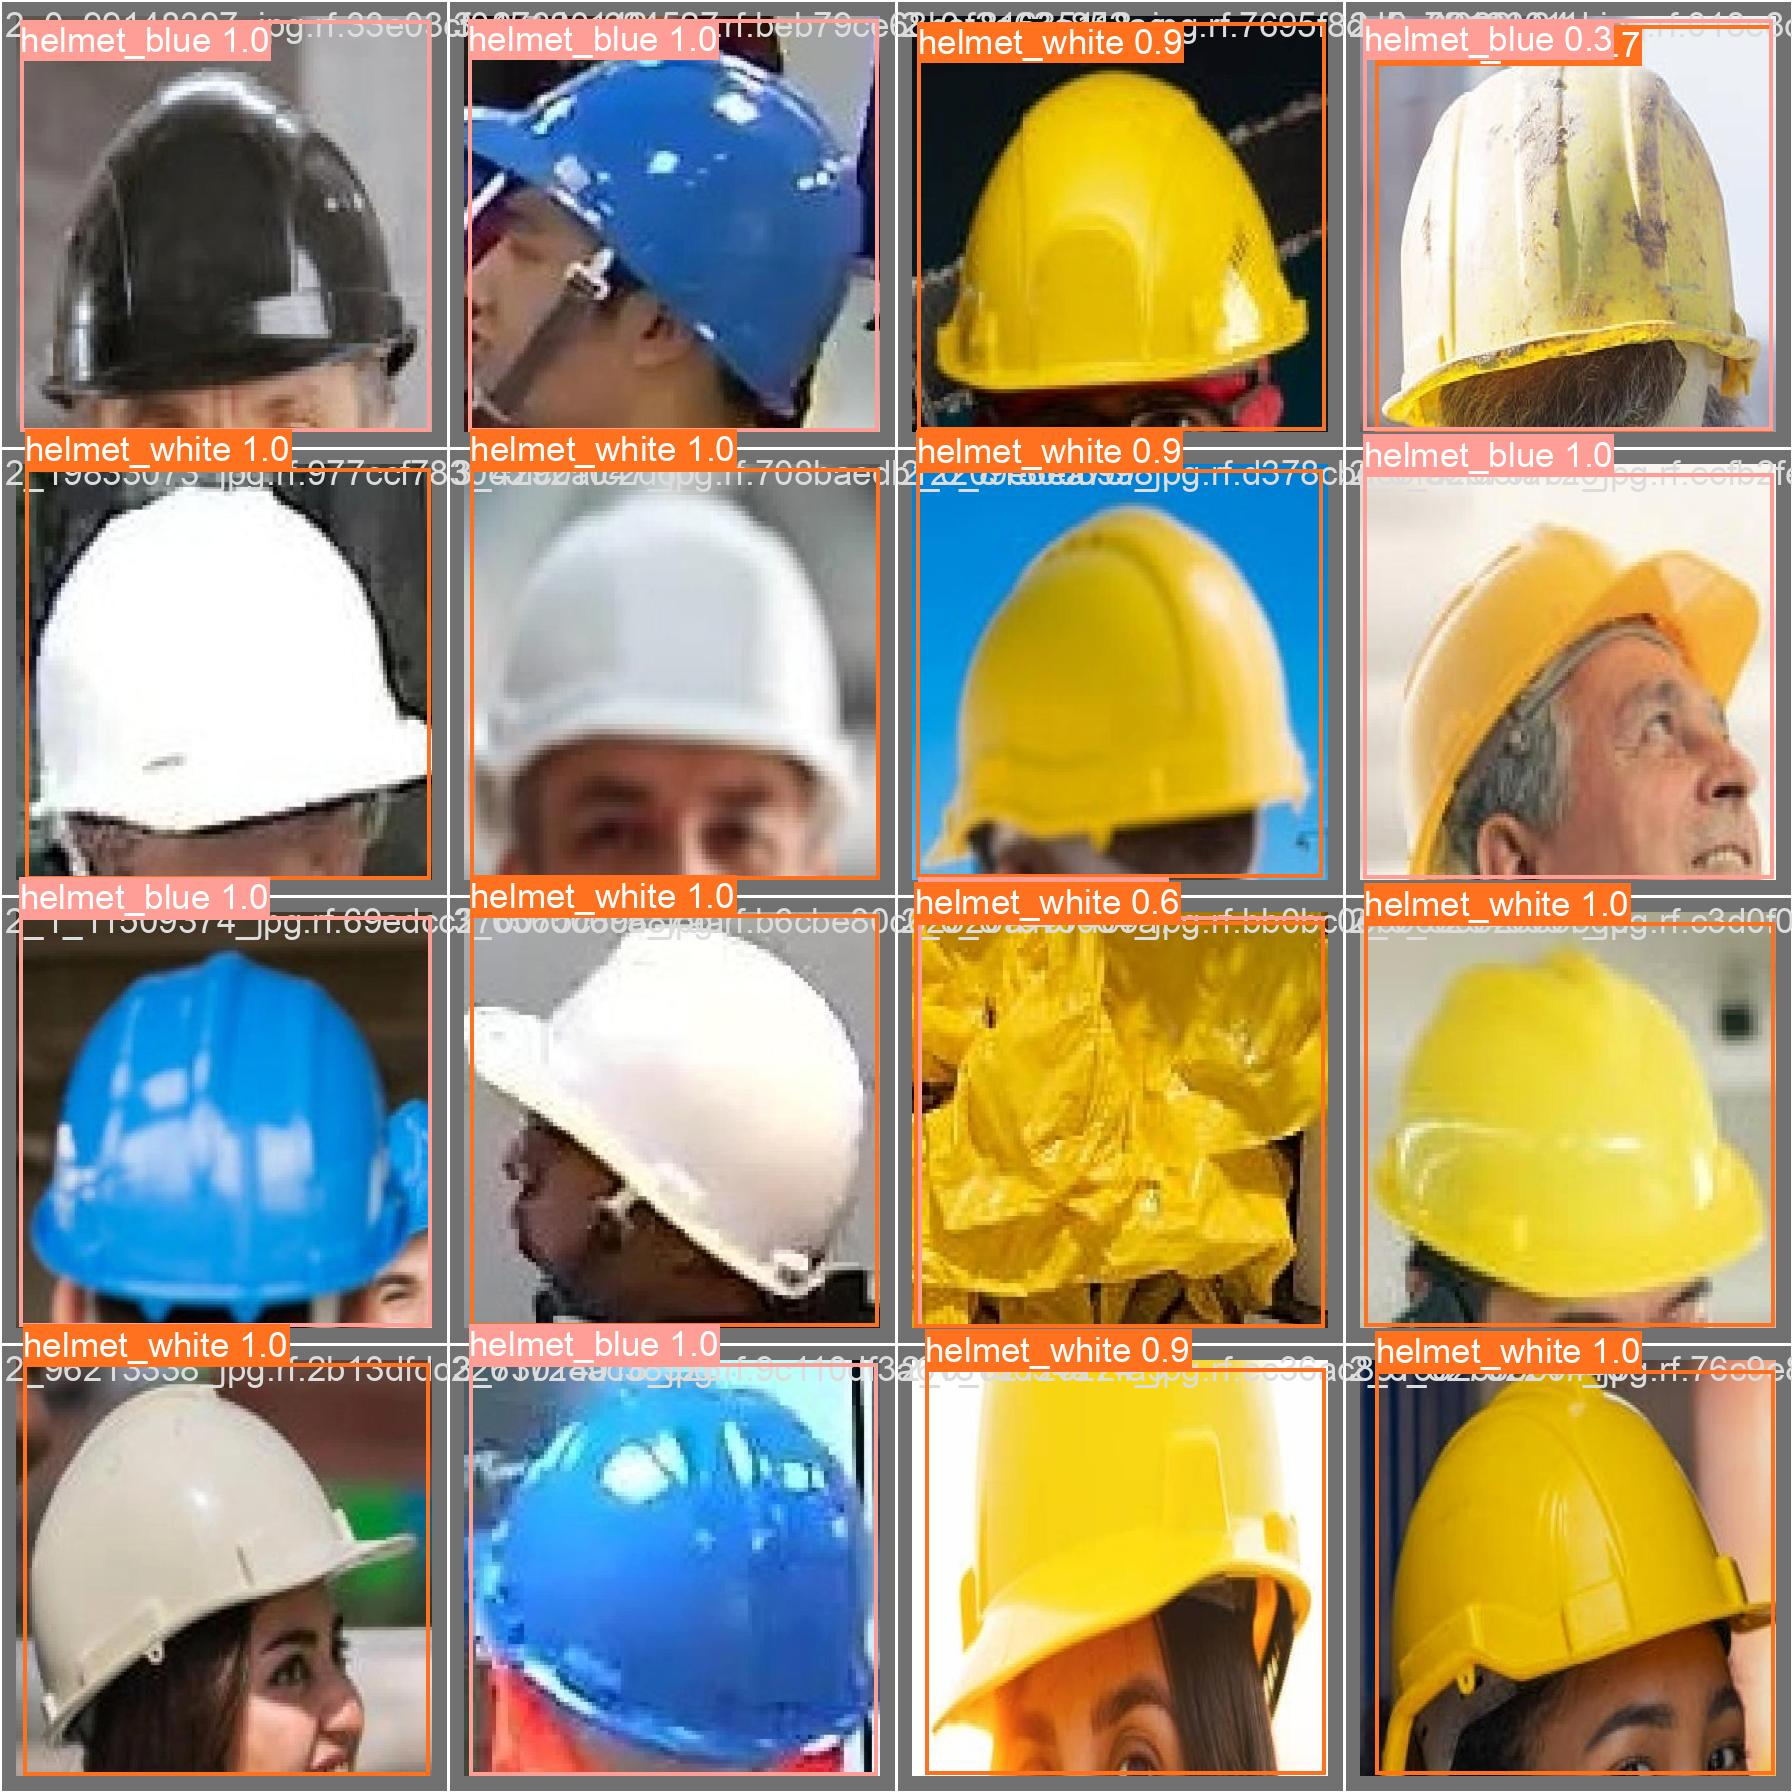

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

In [ ]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

/content
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.7 source={dataset.location}/test/images save=True

/content
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file

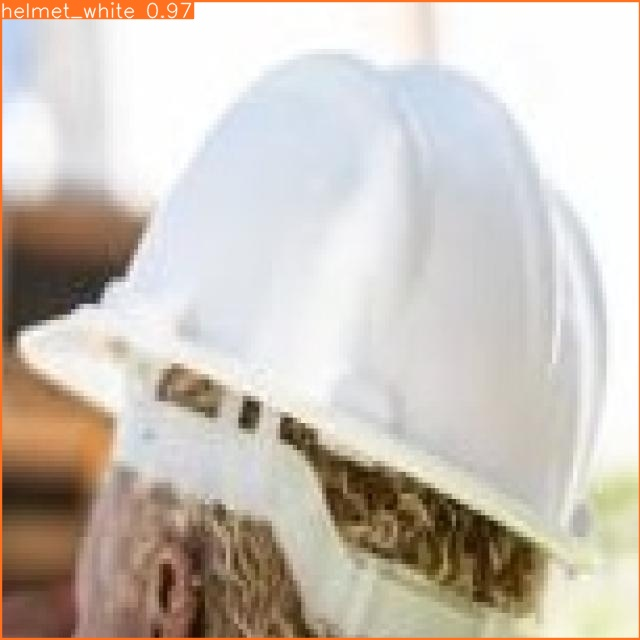

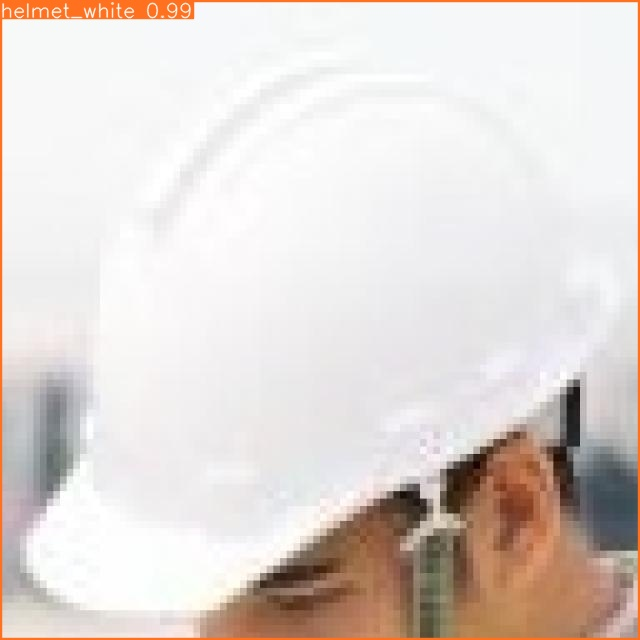

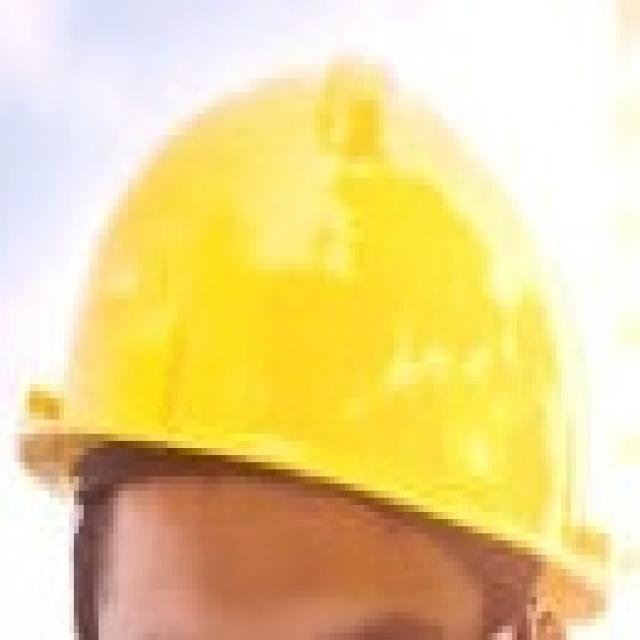

In [ ]:
import glob
from IPython.display import Image, display

# Define the base path where the folders are located
base_path = '/content/runs/detect/'

# List all directories that start with 'predict' in the base path
subfolders = [os.path.join(base_path, d) for d in os.listdir(base_path)
              if os.path.isdir(os.path.join(base_path, d)) and d.startswith('predict')]

# Find the latest folder by modification time
latest_folder = max(subfolders, key=os.path.getmtime)

image_paths = glob.glob(f'{latest_folder}/*.jpg')[:3]

# Display each image
for image_path in image_paths:
    display(Image(filename=image_path, width=600))
    print("\n")